# Predicting Hotel Booking Cancellations

The purpose of this project is to predict whether an advanced booking at a hotel will be cancelled by training classification algorithms on a set features to choose between two classes in the target feature - 1 for cancelled and 0 for not cancelled. Cancellations can lead to a loss in revenue for hotels making it a worthwhile endeavour to predict whether a given booking is likley to cancel. 

Five classifiers (three base, two ensemble algorithms) all from different categories are initially tested. Based on the scoring, one base and one ensemble algorithm will be fine-tuned and tested on a subset of data set aside to act as future, unseed data. Due to the heavy presence of categorical features in this dataset, this project places equal emphasis on data preprocessing as it does with the predictive modelling component.

### Contents

<ul>
  <li>1. Exploratory Data Analysis   
    <ul>
      <li>1.1 Data Characterisitcs</li>
      <li>1.2 Target Feature
      <li>1.3 Data Visualization</li>
      <li>1.4 Correlation</li>
     </ul>
   </li>
   <li>2. Data Preparation and Transformation Pipelines   
     <ul>
      <li>2.1 Splitting the Data</li>
      <li>2.2 Create Custom Transformers</li>
      <li>2.3 Construct Pipeline</li>
     </ul>   
   </li>
   <li>3. Model Selection</li>
   <li>4. Hyperparameter Fine-Tuning   
     <ul>
      <li>4.1 K-Nearest Neighbors</li>
      <li>4.2 Random Forest</li>
      <li>4.3 Evaluation and Comparision of Final Models</li>
     </ul>   
   </li>
   <li>5. Deploying Model on "Real-World" Data</li>
</ul>

This dataset can be found on <a href="https://www.kaggle.com/jessemostipak/hotel-booking-demand">Kaggle</a>, and as per the uploader, "the data is originally from the article Hotel Booking Demand Datasets, written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019."

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [4]:
df = pd.read_csv("hotel_bookings.csv") 
df_eda = pd.read_csv("hotel_bookings.csv") # Load seperate copy for EDA purposes only 
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# 1. EDA

To understand the data better, some exploratory data analysis is done to gather the following information:
<ul>
  <li>View the characteristics of the data, including missing data, variance of the features, outliers, etc.</li>
  <li>Analyze the target attribute and determine any imbalance.</li>
  <li>Data visualization to show the following:   
    <ul>
      <li>Number of bookings vs. lead times (split by cancelled or not)</li>
      <li>Distribution of lead times among segments</li>
      <li>Average daily rate per month</li>
      <li>Average number of bookings by day of the Week and month</li>    
      <li>Distribution of price among reserved room types</li>        
    </ul>
  </li>
  <li>Correlation between numerical features.</li>
</ul>

### 1.1 Data Characteristics

In [5]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

The following data characteristics should be corrected:
* All date/time columns should be considered as categorical (month is already assigned to the correct type). 
* Adults, children and babies columns are oridinal, so children should be converted from float to int. 
* Agent and company are ID columns and should be considered categorical.   

In [6]:
# For features with NaN values, count number of NaN's
na = pd.DataFrame(df_eda.isna().sum(), columns=['NaN'])
na[(na['NaN']>0)]

,NaN
children,4
country,488
agent,16340
company,112593


The above tables summerizes the number of NaN values in the dataset, the features they are found in and how many in each feature. In addition, over 94% of the 'company' feature is missing and therefore provides very little information.

In [7]:
# Drop target, date and categorical attributes
df_describe = df_eda.drop(['is_canceled', 'arrival_date_year', 'arrival_date_week_number', 
                       'arrival_date_day_of_month', 'agent', 'company'], axis=1).describe()
df_describe.transpose()

,count,mean,std,min,25%,50%,75%,max
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0
is_repeated_guest,119390.0,0.031912,0.175767,0.00,0.00,0.000,0.0,1.0
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0
booking_changes,119390.0,0.221124,0.652306,0.00,0.00,0.000,0.0,21.0


The above information shows that most features have a mean of around zero and a small standard deviation around the mean. This could hint that these features may be mostly zeros. The max is also significantly higher than the mean, which could indicate that values are still spread out despite the most of it being zero. To investigate further, the variance can be calculated for each numerical feature to determine the spread of the data. And to understand the data more, the frequency of the most common value (i.e. zero) in each feature can also be calculated.

In [14]:
# Create dataframe for numeric features 
cols = df_describe.columns
df_num = df_eda[cols]

# Find most frequent value, percentage make up of most frequent value, and variance for each feature
most_freq = []
percent = []
var = []
for i in df_num.columns:
    percent.append((df_eda[i].value_counts().max()/df_eda.shape[0]*100))
    most_freq.append(df_eda[i].value_counts().idxmax())
    var.append(np.var(df_eda[i]))

# Apply results to table    
variances_table = pd.DataFrame(index=df_num.columns)
variances_table['Most Frequent Value'] = most_freq
variances_table['Percentage in Feature'] = percent
variances_table['Variance'] = var
variances_table

,Most Frequent Value,Percentage in Feature,Variance
lead_time,0.0,5.314515,11419.625860
stays_in_weekend_nights,0.0,43.553061,0.997221
stays_in_week_nights,2.0,28.213418,3.641523
adults,2.0,75.115169,0.335540
children,0.0,92.801742,0.158850
babies,0.0,99.231929,0.009494
is_repeated_guest,0.0,96.808778,0.030894
previous_cancellations,0.0,94.569059,0.712898
previous_bookings_not_canceled,0.0,96.967920,2.242298
booking_changes,0.0,84.859703,0.425499


Zero is the most common value in all features except "stays_in_week_nights" and "adults". For most features, the most common feature occurs more than 90% of the time - the highest being "babies", with zero making up 99.23% of the data. Some of the less severe features include "adults" and "total_of_special_request", with their most common values making up 75.12% and 58.90% of the data respectively. 

Although zero makes up 96.90% of the "days_in_waiting_list" feature, it has a variance of 309.57 which indicate that the data is infact spread out. However almost all features here show low variance, so its possible that some features bring little information (or predictive power) due to it being almost constant.

In [15]:
from scipy.stats import zscore

# Compute absolute z-scores
zscore = np.abs(zscore(df_num))
df_zscores = pd.DataFrame(data=zscore, columns=df_num.columns)

# Sum z-scores greater than 3 and group by feature
outliers = pd.DataFrame(df_zscores[df_zscores > 3].count(), columns = ['Number of Outliers'])

# Calculate percentage make up in each feature 
outliers['Percentage in Feature'] = outliers['Number of Outliers'].apply(lambda x : x/df.shape[0]*100).round(2)
outliers

,Number of Outliers,Percentage in Feature
lead_time,1454,1.22
stays_in_weekend_nights,2199,1.84
stays_in_week_nights,1669,1.40
adults,481,0.40
children,0,0.00
babies,917,0.77
is_repeated_guest,3810,3.19
previous_cancellations,317,0.27
previous_bookings_not_canceled,936,0.78
booking_changes,1570,1.32


The above table indicates the total number of outliers for each feature using z-score method, all observations are standarized with a standard deviation of 1. Then the z-score for each observation is computed. Any score greater than 3 or less than -3 is considered to be an outlier as 99.7% of the data should be within three standard deviations from the mean. 

The percentage of data that the outliers make up in each feature is also included in the second column to gauge how much variation is left in a given feature if its outliers were removed. For example, for 'required_car_parking_spaces', the outliers make up 6.21% of the data. The most common value, zero, makes up 93.79%. If outliers are removed, then the entire feature would be constant at zero and therefore provide no information.

In [16]:
print('Number of unique countries:', df_eda['country'].nunique())
print('Number of unique agents:', df_eda['agent'].nunique())

Number of unique countries: 177
Number of unique agents: 333


The above are categorical attributes with a large number of unique values: 'country' and 'agent' have 177 and 333 unqiue values respectively, making them more difficult to encode. It may be more productive to group them into bins.

### 1.2 Target Feature

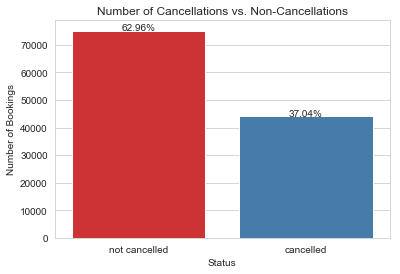

In [17]:
is_canceled = ['not cancelled', 'cancelled']
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))
ax = sns.countplot(x='is_canceled', data=df_eda, palette='Set1')
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+40, '{0:.2%}'.format(height/total), ha="center")
ax.set_xticklabels(is_canceled)
plt.title('Number of Cancellations vs. Non-Cancellations')
ylabel = plt.ylabel("Number of Bookings")
xlabel = plt.xlabel("Status");

The feature being predicted on is whether a booking will cancelled. It is a binary feature with 37.04% of bookings were cancelled vs. 62.96% that were not. This represents a slight class imbalance in the target feature.

### 1.3 Data Visualization

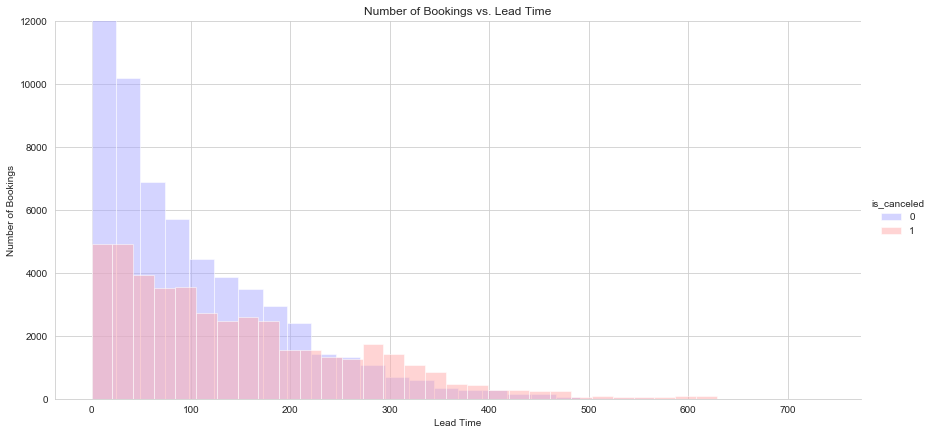

In [18]:
# Plot stacked bar plot. 
g = sns.FacetGrid(df_eda, hue="is_canceled", height=6, aspect=2, palette='bwr')
g = g.map(plt.hist, 'lead_time', bins=30, alpha=0.5).add_legend()
plt.title("Number of Bookings vs. Lead Time")
ylabel = plt.ylabel("Number of Bookings")
xlabel = plt.xlabel("Lead Time")
# To better visualize the bar plot, upper limit of y is reduced to 12,000. 
plt.ylim(0,12000);

When bookings are made a few days in advance, only a fraction of them are cancelled. Note that the actual number in the '0-20' bin extends to 28,000 bookings, however the y limit here is set to 12,000 for clarity of the proceeding bins.

As the lead time increases, the number of cancellations relative to non-cancellations also increase. When bookings are made more than 220 days out, the number of cancellations begin to equal the number of non-cancellations. Starting at around 280 days out, there are more cancellations than there are retained bookings. The next step is to analyze how lead time is distributed among the market segment.

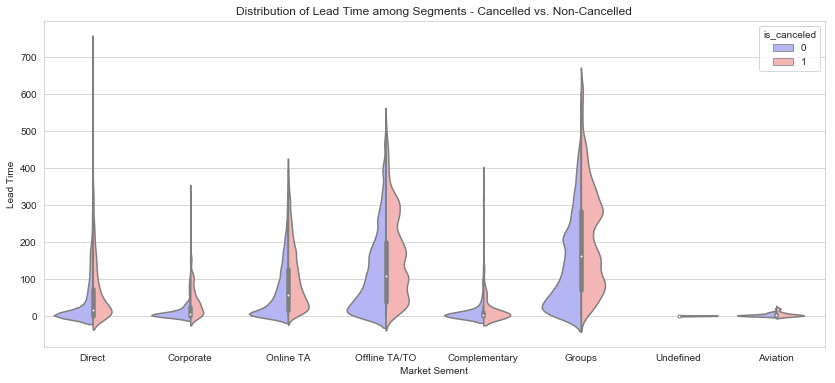

In [19]:
plt.figure(figsize=(14,6))
sns.violinplot(x='market_segment', y='lead_time', data=df_eda, hue='is_canceled', split=True, palette='bwr')
plt.title("Distribution of Lead Time among Segments - Cancelled vs. Non-Cancelled")
ylabel = plt.ylabel("Lead Time")
xlabel = plt.xlabel("Market Sement");

This violinplot summerizes the distribution of lead time among the observed market segments, which is further seperated by cancelled (red) vs. non-cancelled bookings (blue). Bookings that were made from direct, corporate, complementary and aviation channels typically have short lead times (under 100 days), with aviation providing the shortest notice. The distribution of cancelled vs. non-cancelled appear to be similar for those particular channels, except corporate bookings which can be expected to cancel when the lead time around 50 days or more. 

Online TA, offline TA/TO, and groups contribute heavily towards lead times in excess of 100 days. As expected, cancellations begin to outnumber retained bookings in those groups as the lead time increases. With that said, it does not appear that any particular segment contributes to more cancellatations. They all contribute evenly in proportion to the bookings they generage.

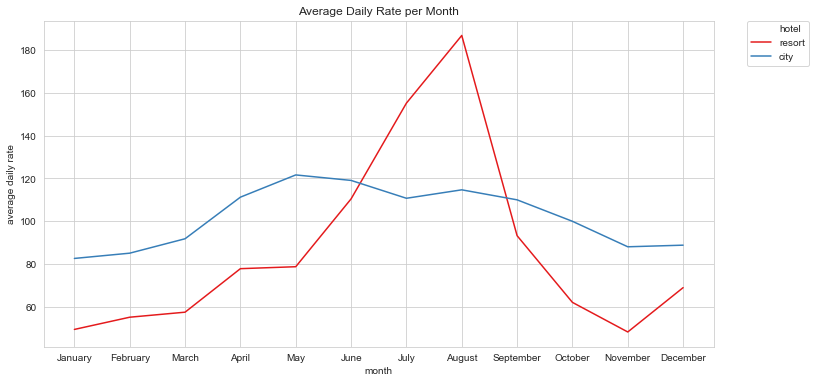

In [20]:
# Drop outlier with adr = 5400
df_line = df_eda.drop(df_eda[df_eda['adr']== df_eda['adr'].max()].index)

# Create dataframes for resort and city hotels based on average price for every month
price_resort = df_line[(df_line['hotel']=='Resort Hotel')].groupby('arrival_date_month').mean()['adr']
price_city = df_line[(df_line['hotel']=='City Hotel')].groupby('arrival_date_month').mean()['adr']
price_resort_df = pd.DataFrame({"month": list(price_resort.index), "hotel": "resort", "average daily rate": list(price_resort)})
price_city_df = pd.DataFrame({"month": list(price_city.index), "hotel": "city", "average daily rate": list(price_city)})

# Concatnate dataframes and convert 'month' to ordered categorical data
price_per_month = pd.concat([price_resort_df,price_city_df])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
price_per_month['month'] = pd.Categorical(price_per_month['month'], ordered=True, categories=months)

# Plot lineplot
plt.figure(figsize=(12,6))
sns.lineplot(x='month', y='average daily rate', hue='hotel', data=price_per_month, sort=True, palette='Set1')
plt.title('Average Daily Rate per Month')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

The daily rate for both the resort and city hotel are clearly higher in the summer months compared to the cooler months. Rates for resort hotels peak in July and August. For city, the rates are reduced slightly during these months, possibly to compete with resort hotels. However the rates for resort are generally cheaper throughout the year, and are only more expensive then city during June to August. During this part of the analysis, it was discovered that there was an outlier with an apr = 5400, which was removed for this visualization. 

The next part of the analysis requires the days of the week (Monday, Tuesday, etc.) not availble in the raw data. Fortuantely with calendar.weekday this information can be generated if year, month, and day is given. However some intial preprocessing is required.

In [21]:
import calendar 
# map new column with month interger of each record 
month_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 
              'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
df_eda['month'] = df_eda['arrival_date_month'].map(month_dict)

# define function to return weekday from date and apply to new column
def week_func(x): 
    dayNumber = calendar.weekday(x['arrival_date_year'], x['month'], x['arrival_date_day_of_month']) 
    days =['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] 
    return (days[dayNumber]) 

df_eda['weekday'] = df_eda.apply(week_func, axis=1)

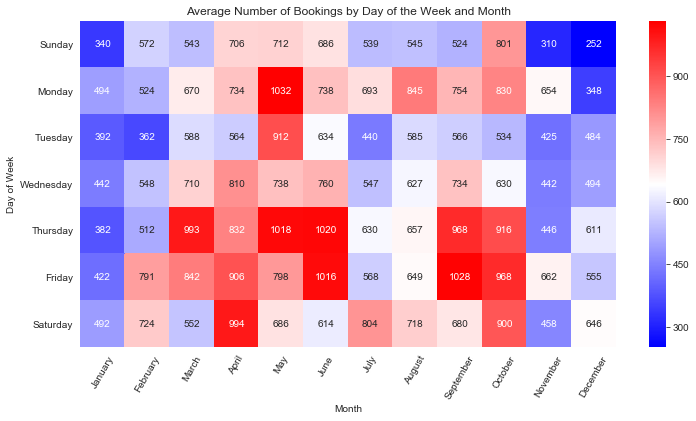

In [22]:
# Now that the days of the week are available for each record, inference can be done using this new information
# Groupby using weekday and month with count as aggregate
df_eda = df_eda.assign(booking_id=np.arange(len(df))).reset_index(drop=True)
byweekmonth = df_eda.groupby(by=['weekday','arrival_date_month']).count()['booking_id'].unstack(level=1)
byweekmonth = byweekmonth.loc[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']]

# Divide counts in Jul and Aug by 3 and all other months by 2 to calculate the average count per month
jul_aug = byweekmonth[['July','August']].apply(lambda x : x/3, axis=1).round()
byweekmonth = byweekmonth.drop(['July','August'],axis=1)
byweekmonth = byweekmonth.apply(lambda x : x/2, axis=1).round()
byweekmonth = pd.concat([jul_aug, byweekmonth], axis=1)
byweekmonth = byweekmonth.astype(int)
byweekmonth = byweekmonth[months]

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(byweekmonth, annot=True, cmap='bwr', fmt="d")
plt.title("Average Number of Bookings by Day of the Week and Month")
plt.xticks(rotation=60)
ylabel = plt.ylabel("Day of Week")
xlabel = plt.xlabel("Month")

The dataset contains data from July 2015 to August 2017. So while most months appear twice, the months of July and August appear three times and therefore provide an extra month of data each. To account for this, the count for Jul and Aug is divided by 3. All other months are divided by 2.

It can be inferred from the heatmap that the there are more bookings during the summer months. Bookings start reduce during the fall months and pick back up again during spring. In addition, most check-ins tend to start in the later part of the week, i.e Thrusday and Friday. Monday also appears to be a popular day of the week to check-in. There seems to be a cooldown in bookings during the months of July and August which may intuitively seem incorrect. This drop can be rationalized when price is considered. From a previous analysis, it was determined that these months are when prices peak, which could lead to people avoiding travel during that time.

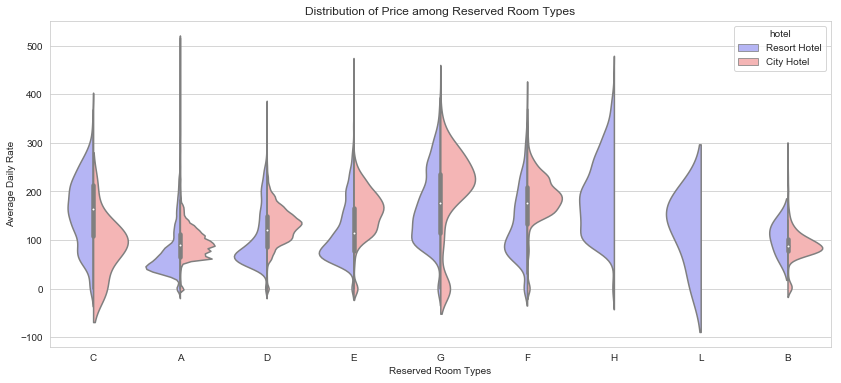

In [23]:
# Drop rows with reserved_room_type = P which only listed apr = 0 
df_violin = df_line.drop(df_line[(df_line['reserved_room_type']=='P')].index)

# Plot violin plot
plt.figure(figsize=(14,6))
sns.violinplot(x='reserved_room_type', y='adr', data=df_violin, hue='hotel', split=True, palette='bwr')
plt.title("Distribution of Price among Reserved Room Types")
ylabel = plt.ylabel("Average Daily Rate")
xlabel = plt.xlabel("Reserved Room Types");

As per the uploader of the dataset, the room type is coded for anonymity reasons. During this analysis, it was discovered that each booking under the reserved room type 'P' was listed with an adr of 0. For this portion, room type 'p' is removed from the dataset as it provides no information.

The violin plot shows the distribution of price across different room types. The first thing to note is that room type 'H' and 'L' does not exist for city hotels. Rooms that available at both types of hotels generally see prices for city hotels higher than their resort counterpart, with the exception of room type 'C' and possible 'B'. An advantange of the violin plot over the boxplot is the ability to visualize the probability density of the data at different prices. In addition, multiple peaks can be seen for some room types, indicating that pricing is centered around various levels from some rooms.

### 1.4 Correlation Between Features

Before calculating correlations, some categorical features can be encoded into numerical format to analyze their correlations as well. This includes encoding the "hotel" feature, and one hot encoding the "customer_type", "deposit_type" and "reservation_status" features.

In [24]:
# Encode hotel into binary format
hotel_class = pd.get_dummies(df_eda['hotel'],drop_first=True).rename(columns={'Resort Hotel':'hotel'})
# Apply one hot encoding the following features
customer_type_class = df_eda['customer_type'].str.get_dummies()
deposit_type_class = df_eda['deposit_type'].str.get_dummies()
reservation_status_class = df_eda['reservation_status'].str.get_dummies()
# Concat df_num and encoded features
df_num = pd.concat([df_eda['is_canceled'], hotel_class, df_num, customer_type_class, deposit_type_class, reservation_status_class], axis=1)

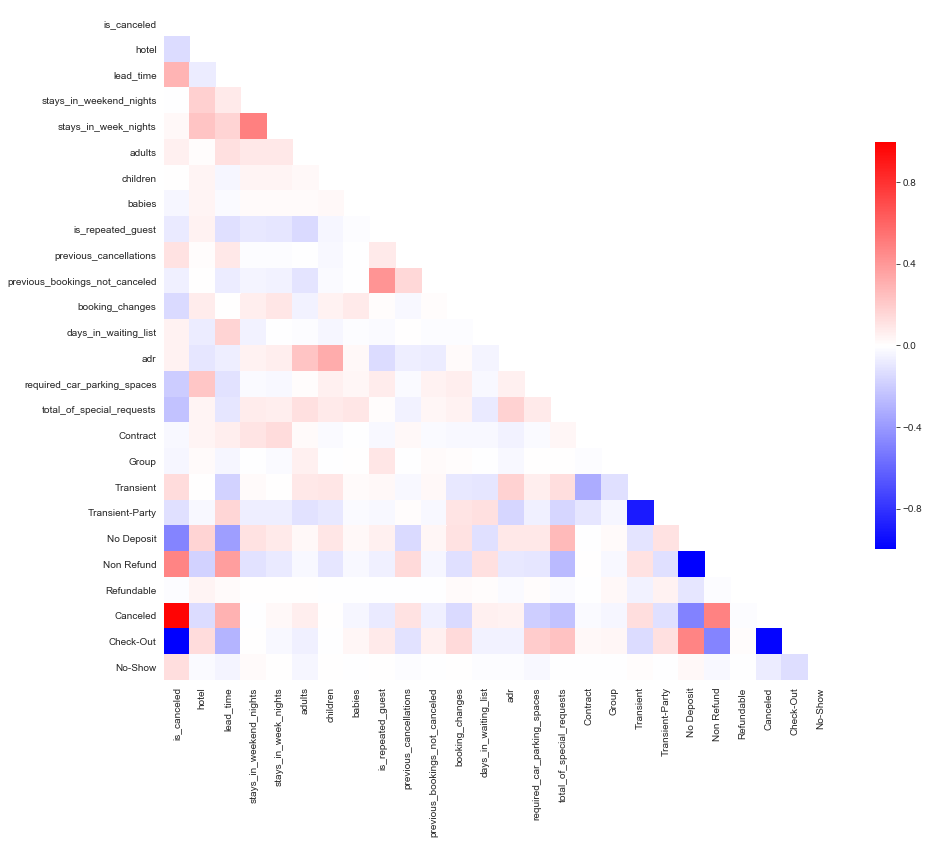

In [27]:
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(df_num.corr(), dtype=np.bool))
sns.heatmap(df_num.corr(), mask=mask, square=True, cmap='bwr', cbar_kws={"shrink": .5});
sns.set(style="white")

The matrix does not indicate strong correlation for most of the features, however there is strong correlation between some. The labels in the 'reservation_status' feature appear to have direct correlation with the target feature and should therefore be removed prior to modelling. This makes sense for future predictions as the reservation status is not known at the time the booking is made.

## 2. Data Preparation & Transformation Pipelines

In [178]:
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

### 2.1 Splitting the Data

In [180]:
# Define X and y
y = df['is_canceled']
X = df.drop(['is_canceled'], axis=1)

In [181]:
# Convert int to float
X[['lead_time','days_in_waiting_list']] = X[['lead_time','days_in_waiting_list']].astype(float)

In [182]:
# Partition data by 60% train set, 20% validation set, 20% test set. 
train_set_X, test_X, train_set_y, test_y = train_test_split(X, y, test_size=0.2)
train_X, validate_X, train_y, validate_y = train_test_split(train_set_X, train_set_y, test_size=0.25)

Based on the observations made in the previous sections, the data will be preprocessed as follows:

* The feature <b>'company'</b> will be dropped since 94% of the feature is missing. The feature <b> 'reservation_status' </b> will be dropped due to direct correlation with the target feature. <b> reservation_status_data </b> will be dropped as it provides little information.
* The feature <b>'is_repeated_guest'</b> is already binary. The <b>'hotel'</b> attribute should be encoded into binary format. All other categorical attributes should be one hot encoded.
* <b>'country'</b> contains 177 unique values. Countries that generate less than a specified amount of booking will be grouped together.
* <b>'agent'</b> contains 333 unique values. Agents will discretized into bins based on the amount of bookings they generate.
* Using the 'week_func' function in the previous section, a weekday column will be generated. The features <b>'arrival_date_week_number'</b> and <b>'arrival_date_day_of_month'</b> will be dropped to reduce dimensionality.
* All missing values for numerical features will be assigned 0 as a placeholder, catergorical features will be assigned 'unknown'.
* All categorical features will be one hot encoded

### 2.2 Build Custom Transformers

Prior to constructing the transformation pipeline, some custom transformers are needed to handle the following:

* Discretize the 'agent' feature into bins based on the number of bookings they generate.
* Group low count countries in the 'country' feature into one group.
* Create a weekday column based on the date info already given in dataset.

In [34]:
class AgentDiscretizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, bins=1):
        self.bins = bins

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['agent'].fillna('unknown', inplace=True)
        vc = pd.DataFrame(X_copy['agent'].value_counts()).reset_index()
        
        vc['agent_bins'] = pd.cut(vc.iloc[:,1], bins=self.bins, labels=False)
        vc['agent_bins'] = vc['agent_bins'].astype(str)
        
        for i in vc['agent_bins'].unique():
            vc['agent_bins'] = vc['agent_bins'].replace({i: 'agent_bin_'+ i})

        X_copy = X_copy.merge(vc[['index','agent_bins']], left_on='agent', right_on='index', how='left').drop(['agent','index'],axis=1)
        return X_copy

The above transformer takes one hyperparamter, "bins", which is the number of equal-width bins to discretize the 'agent' column subject to their count in the dataset. The transformer will then generate a new feature for the assigned labels of each agent based the bin they fall under. Finally, the 'agent' feature will be dropped from the dataset.

In [35]:
class CountryGrouper(BaseEstimator, TransformerMixin):
    
    def __init__(self, group_count=0):
        self.group_count = group_count
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['country'].fillna('unknown', inplace=True)
        vc = X_copy['country'].value_counts()
        for i in vc[vc <= self.group_count].index.tolist():
            X_copy['country'] = X_copy['country'].replace({i: 'OtherGroup'})
        return X_copy

This next transformer takes one hyperparameter, "group_count", which is the threshold to apply the grouping when a country's count is less than or equal to the threshold. For ex. if group_count = 1, countries that produce only one booking will be grouped together under the label, 'OtherGroup'. Note that it will first convert all missing values to 'unknown'. 

In [36]:
class WeekdayCreator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['month'] = X_copy['arrival_date_month'].map(month_dict)
        X_copy['weekday'] = X_copy.apply(week_func, axis=1)  # function borrowed from data visualization step 
        X_copy = X_copy.drop(['month', 'arrival_date_week_number', 'arrival_date_day_of_month'],axis=1)
        return X_copy

The last custom transformer utilizes that dataset's 'arrival_date_year', 'arrival_date_month' and 'arrival_date_day_of_month' to generate the day of the week associated with a given record (i.e. Monday, Tuesday, etc.). After which, the 'arrival_date_week_number' and 'arrival_date_day_of_month' features are dropped.

### 2.3 Construct Pipeline

In [37]:
# Define features to be one hot encoded.
X_cat = ['arrival_date_year', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 
         'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'agent_bins', 
         'weekday']

In [132]:
# Create transformation pipeline to target specific features 
preprocess_scaled = ColumnTransformer(transformers=[('drop_columns', 'drop', ['company','reservation_status','reservation_status_date']),
                                                    ('scaler', StandardScaler(), ['adr']),
                                                    ('impute_num', SimpleImputer(strategy='constant', fill_value=0), ['children']),
                                                    ('hotel_enc', OrdinalEncoder(), ['hotel']),
                                                    ('cat_enc', OneHotEncoder(handle_unknown='ignore'), X_cat)],
                                      remainder='passthrough',
                                      sparse_threshold=0)

In [133]:
full_preprocess = Pipeline([('weekdays', WeekdayCreator()),
                            ('group_countries', CountryGrouper(group_count=100)), 
                            ('agent_bins', AgentDiscretizer(bins=20)),
                            ('preprocess', preprocess_scaled),
                            ('variance_threshold', VarianceThreshold(threshold=(.05)))])

The full preprocessing steps will first apply the three custom transformers to the data, followed by the preprocessing steps that target specific features, and then finally as a feature selection method the variance threshold will select features that meet the specified variance threshold. 

Some parameters are intially tweaked for the model selection phase:
* All countries that produce 100 or less bookings will be grouped together in the 'country' feature.
* Agent numbers are discretized into 20 equal-width bins in the new 'agent_bins' feature. 
* Variance threshold is set to 0.05

<i> Keep in mind that for the binary features (Bernoulli random variables) variance is calculated as: Var(x) = p(1−p). </i>

In [197]:
# Prepare the training data for the model selection phase
train_X_prepared = full_preprocess.fit_transform(train_X)

## 3. Model Selection

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import make_scorer, f1_score

In this section, five "quick and dirty" classifiers will be trained from various categories: linear, naive Bayes, neighbors, and two ensemble methods (one bagging and one boosting). Since almost all features are in binary, the KNN classifier will be using the Hamming distance metric. Similarlily the Naive Bayes algorithm used will be the Bernoulli naive Bayes since it is best suited to handle binary features. The other base estimator is logistic regression, and the ensemble methods are random forest and gradient boosting.

Due to target class imbalance, the accuracy score may not fully represent a model's strength given that a high score can still be obtained if most of the predictions were made for the majority class. A better altnerative may be observing how well the models predicted the minority class, i.e. 1 in 'is_canceled'. Afterall, the purpose of this project is to assist hotels in predicting cancellations. With that said, the f1-score (or the harmonic mean of precision and recall) for the minority class will also be used. To accomplish this, a custom scorer is be created.

In [45]:
# Create custom metric using the f1-score for minority class in target feature (1). 
f1_scorer = make_scorer(f1_score, pos_label=1)

In [46]:
# Specify 10 folds for CV
skfold = StratifiedKFold(n_splits=10, shuffle=True)

In [47]:
# Create list of models to be trained 
estimators = [('KNN', KNeighborsClassifier(n_neighbors=5, metric='hamming')),
              ('Logistic Regression', LogisticRegression(solver='lbfgs', max_iter=4000)),
              ('Naive Bayes', BernoulliNB()),
              ('Random Forest', RandomForestClassifier(n_estimators=100)),
              ('Gradient Boosting', GradientBoostingClassifier())]

In [317]:
f1, accuracy, names  = [], [], []
for name, estimator in estimators:
    
    # Using 10-fold CV, obtain f1-scores and accuracy scores
    f1_scores = cross_val_score(estimator, train_X_prepared, train_y, cv=skfold, scoring=f1_scorer)
    accuracy_scores = cross_val_score(estimator, train_X_prepared, train_y, cv=skfold, scoring='accuracy')
    
    # Fill lists with scores for boxplot visualization step
    f1.append(f1_scores)
    accuracy.append(accuracy_scores)
    names.append(name)
    
    print('%s f1-score: %.2f%%, accuracy: %.2f%%' % (name, 100*f1_scores.mean(), 100*accuracy_scores.mean()))

KNN f1-score: 76.22%, accuracy: 82.80%
Logistic Regression f1-score: 74.25%, accuracy: 82.25%
Naive Bayes f1-score: 63.99%, accuracy: 77.29%
Random Forest f1-score: 84.17%, accuracy: 88.60%
Gradient Boosting f1-score: 79.15%, accuracy: 85.46%


Overall accuracy is pretty good for each 'quick and dirty' classifier after the data transformation; the lowest scoring model is the Bernoulli Naive Bayes at 77.29% accuracy, and highest being Random Forest at 88.60% accuracy. 

As previously stated, the f1-score for the minority class would better describe the strenth of each model given the class imbalance of the target feature. Using this measure, the classifiers don't look as great however with the exception on the Naive Bayes model, they all seem to perform quite well given little to no tuning of its parameters. Random Forest is still leading with an f1-score of 84.17%.

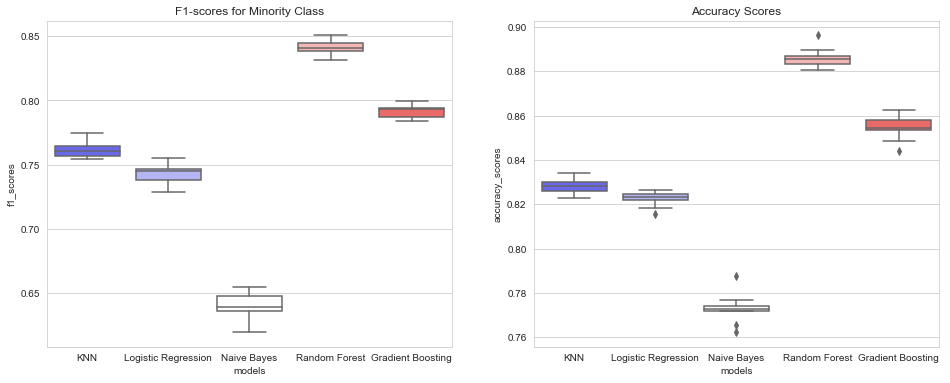

In [393]:
models = [y for x in names for y in (x,)*10]
f1_scores = [item for sublist in f1 for item in sublist]
accuracy_scores = [item for sublist in accuracy for item in sublist]
df_f1 = pd.DataFrame({'models':models, 'f1_scores':f1_scores})
df_accuracy = pd.DataFrame({'models':models, 'accuracy_scores':accuracy_scores})

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
sns.boxplot(x='models', y='f1_scores', data=df_f1, palette='bwr', ax=ax1)
ax1.set_title('F1-scores for Minority Class')
sns.boxplot(x='models', y='accuracy_scores', data=df_accuracy, palette='bwr', ax=ax2)
ax2.set_title('Accuracy Scores');

Boxplots are used to visualize each individual score from the 10-fold CV of each model. For both scoring metrics, the distribution of scores for each classifier is small. This shows very distinct performances across the classifiers with the exception of KNN and logisitic regression model where they are observed to have comparable performance. There are instances of logistic regression scoring higher accuracy than KNN.

The purpose of this project is to select one base and one ensemble estimator for further study. Based on performance, the KNN and Random Forest model will selected. 

## 4. Hyperparameter Tuning

In [256]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In this section, the validation set is utilized to test for any improvements in the model from fine-tuning parameters in both the estimators and the preprocessing pipeline (including some of the custom transformers created earlier). To enforce consistency, a pipeline chaining the estimators and preprocessing pipeline is used to conduct the testing.

### 4.1 K Nearest Neighbors

KNN is a lazy learner as it will wait until prediction time to search the entire training set to build its model. For this reason, it is very time consuming to gridsearch or iterate predictions through loops to fine-tune hyperparameters. In addition, the Hamming distance, which is used to compare binary data, does not work with the KDtree algorithm in Scikit-Learn so brute-force search is the only option. For these reasons, an interative approach is taken to optimize the model where each successive step uses the optimal parameters found in the step before it:
<ol>
<li>Select an optimal k value.</li>
<li>Compare different distance measures.</li>
<li>Gridsearch preprocessors in pipeline.</li>
</ol>

To find the optimal k value, an elbow plot is graphed to visualize the error rate for each additional neighbor. 25 different KNN models are essentially trained on the training set, and predicted on the validation set and the number of wrong predictions made by each model is recorded. The validation set is preprocessed using the same pipeline as the training set. 

In [198]:
validate_X_prepared = full_preprocess.transform(validate_X)

In [200]:
errors = []
for i in range(1,25):
    
    knn_test = KNeighborsClassifier(n_neighbors=i, metric='hamming')
    knn_test.fit(train_X_prepared, train_y)
    pred_knn_i = knn_test.predict(validate_X_prepared)
    errors.append(np.mean(pred_knn_i!=validate_y))

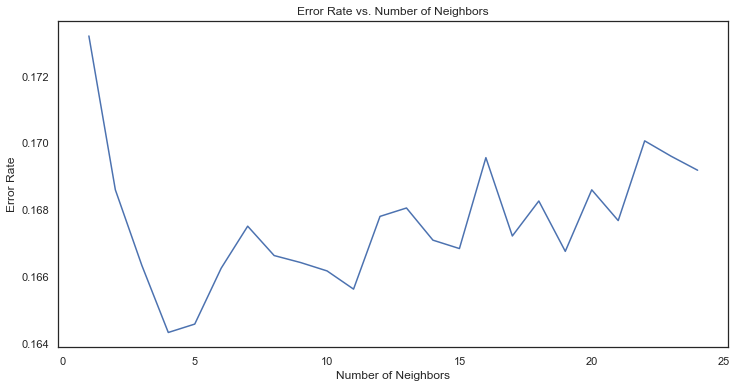

In [215]:
plt.figure(figsize=(12,6))
plt.plot(range(1,25), errors)
plt.title('Error Rate vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error Rate');

As per above, the optimal number of neighbors is when k=4, i.e where the error rate is at its lowest and any point higher would clearly increase the error.

Next, various distance measures are compared using 3-fold CV. The Hamming distance is a popular distance measure for categorical (binary) features and was chosen as the deafult metric previously. Other metrics that can handle binary data include the Jaccard, Dice and Kulsinski distances, as well as the Rogers–Tanimoto measure.

In [223]:
distances = ['hamming','jaccard','dice','kulsinski','rogerstanimoto']
sk3fold = StratifiedKFold(n_splits=3, shuffle=True)

for distance in distances:
    
    f1_scores = cross_val_score(KNeighborsClassifier(n_neighbors=4, metric=distance), 
                                train_X_prepared, train_y, cv=sk3fold, scoring=f1_scorer)
    accuracy_scores = cross_val_score(KNeighborsClassifier(n_neighbors=4, metric=distance),
                                      train_X_prepared, train_y, cv=sk3fold, scoring='accuracy')
    
    print('%s f1-score: %.2f%%, accuracy: %.2f%%' % (distance, 100*f1_scores.mean(), 100*accuracy_scores.mean()))

hamming f1-score: 72.21%, accuracy: 82.21%
jaccard f1-score: 72.31%, accuracy: 81.84%
dice f1-score: 72.59%, accuracy: 82.10%
kulsinski f1-score: 72.02%, accuracy: 81.82%
rogerstanimoto f1-score: 72.28%, accuracy: 82.13%


The CV results yield little to no difference between the various distance metrics. Therfore the more popular Hamming distance will be retained for the model.

The next step involves testing the various parameters in the transformation pipeline. First a prediction is made on the validation set so that its results can be used as a comparison for any performance differences.

In [258]:
# Combine transformation pipeline and KNN estimator 
knn_pipeline = Pipeline([('full_preprocess', full_preprocess), 
                         ('KNN', KNeighborsClassifier(n_neighbors=4, metric='hamming'))])

In [259]:
knn_pipeline.fit(train_X, train_y)
pred_knn_model = knn_pipeline.predict(validate_X)

In [260]:
print(classification_report(validate_y,pred_knn_model))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88     14967
           1       0.86      0.67      0.75      8911

    accuracy                           0.84     23878
   macro avg       0.84      0.80      0.81     23878
weighted avg       0.84      0.84      0.83     23878



In comparison to the KNN model with k=5, this new model has higher accuracy at 84% however with a slightly lower f1-score for the minority class. Indeed the error rate used to locate the optimal k value merely reports all predictions that were incorrect not accounting for the class imbalance. This could have lead to a higher precision but with a slight reduction in recall. 

The gridsearch below will focus on three transformers from the preprocessing pipeline: the number of bins to categorize agents, the threshold to group countries into the 'OtherGroup' when their count doesn meet the threshold, and the variance threshold to remove features that don't meet the threshold. Notice that the scording metric used for GridSearchCV is once again the f1-score for the minority class, as that is the focus. 

In [246]:
#import pprint as pp
#pp.pprint(sorted(knn_pipeline.get_params().keys()))

knn_param_grid = {'full_preprocess__agent_bins__bins': [3, 9, 15, 20],
                  'full_preprocess__group_countries__group_count': [20, 100, 500, 1000],
                  'full_preprocess__variance_threshold__threshold': [0.025, 0.05, 0.1, 0.2]}

In [249]:
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, scoring=f1_scorer, refit=True, verbose=3)
knn_grid.fit(train_X, train_y)
knn_grid.best_params_

{'full_preprocess__agent_bins__bins': 3,
 'full_preprocess__group_countries__group_count': 500,
 'full_preprocess__variance_threshold__threshold': 0.025}

In [302]:
# Change pipeline params as per gridsearch output above.
knn_preprocess = Pipeline([('weekdays', WeekdayCreator()),
                           ('group_countries', CountryGrouper(group_count=500)), 
                           ('agent_bins', AgentDiscretizer(bins=3)),
                           ('preprocess', preprocess_scaled),
                           ('variance_threshold', VarianceThreshold(threshold=(0.025)))])

# Chain new preprocessing pipeline with estimator.
knn_pipeline_tuned = Pipeline([('knn_preprocess', knn_preprocess), 
                               ('KNN', KNeighborsClassifier(n_neighbors=4, metric='hamming'))])

# Fit pipeline on training set and predicting on validation set. 
knn_pipeline_tuned.fit(train_X, train_y)
pred_knn_pipeline_tuned = knn_pipeline_tuned.predict(validate_X)
print(classification_report(validate_y, pred_knn_pipeline_tuned))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     14967
           1       0.85      0.67      0.75      8911

    accuracy                           0.83     23878
   macro avg       0.84      0.80      0.81     23878
weighted avg       0.83      0.83      0.83     23878



The 'optimal' transformer parameters appears to have little effect on the model performance, in fact, accuracy was reduced by one point. Unfortuantely due to the computational time of KNN, only 4x4x4=64 combinations could be passed into the above gridsearch adding to its ineffectiveness in searching hyperparameters. With that said, the above process is kept in to serve primarily as demonstration.

<i> Note: if recall was more important than precision, it is possible to increase the recall at the expense of precision by adjusting the decision threshold of the model. </i>

### 4.2 Random Forest

Random forest is an ensemble learning method that uses a technique called bagging. It works by training many decision trees on random subsets of the training data. It then makes predictions by aggregating the predictions of all the trees. Typically in RF each individual tree is allowed to grow unconstrained since the aggregation will offset the bias. For that reason, the pruning parameters will be untouched in this section. With respect to the preprocessors, the same trasnformers from the previous section will also be tuned here.

First, a model without any tuning is trained and tested on the validation set:

In [283]:
# Build pipeline with preprocessors and RF model
rf_pipeline = Pipeline([('full_preprocess', full_preprocess), ('rf', RandomForestClassifier(n_estimators=100))])

# Test on validation set
rf_pipeline.fit(train_X, train_y)
pred_rf_model = rf_pipeline.predict(validate_X)

In [284]:
print(classification_report(validate_y, pred_rf_model))

              precision    recall  f1-score   support

           0       0.90      0.94      0.91     14967
           1       0.88      0.82      0.85      8911

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878



Results on the validation set are already quite good without any tuning. Overall accuracy is at 89%. With respect to the minority class, the model with the preprocessing steps was correct in its predictions 88% of the time, and was able to catch 82% of the actual cancellations. 

In comparison to KNN, random forest will far less time to make predictions so there should be no issues passing in the entire pipeline into GridSearachCV to locate hyperparameters for the transformers and the estimator. But again, due to limitations only a small range of hyperparameters can be searched at once.

In [294]:
#pp.pprint(sorted(rf_pipeline.get_params().keys()))

rf_param_grid = {'full_preprocess__agent_bins__bins': [5, 10, 20],
                 'full_preprocess__group_countries__group_count': [20, 50, 100],
                 'full_preprocess__variance_threshold__threshold': [0, 0.01, 0.05],
                 'rf__n_estimators': range(100,300,50), 
                 'rf__max_features': range(10,50,10)}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring=f1_scorer, refit=True, verbose=3)
rf_grid.fit(train_X, train_y)
rf_grid.best_params_

{'full_preprocess__agent_bins__bins': 10,
 'full_preprocess__group_countries__group_count': 20,
 'full_preprocess__variance_threshold__threshold': 0,
 'rf__max_features': 40,
 'rf__n_estimators': 200}

In [295]:
rf_preprocess = Pipeline([('weekdays', WeekdayCreator()),
                          ('group_countries', CountryGrouper(group_count=20)), 
                          ('agent_bins', AgentDiscretizer(bins=10)),
                          ('preprocess', preprocess_scaled),
                          ('variance_threshold', VarianceThreshold(threshold=0))])

rf_pipeline_tuned = Pipeline([('knn_preprocess', rf_preprocess), 
                              ('rf', RandomForestClassifier(n_estimators=200, max_features=40))])

# Fit pipeline on training set and predicting on validation set. 
rf_pipeline_tuned.fit(train_X, train_y)
pred_rf_pipeline_tuned = rf_pipeline_tuned.predict(validate_X)
print(classification_report(validate_y, pred_rf_pipeline_tuned))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     14967
           1       0.88      0.83      0.85      8911

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878



The above RF model uses 200 trees and a max of 40 features are sampled for each prediction. Performance increase offered from the gridsearch was very minimal. Overall accuracy and f1-score for the minorty class remained the same (recall for the minority class increased by a point). 

### 4.3 Evaluation and Comparision of Final Models

As a final evaulation measure, the ROC curve for the final KNN and Random Forest model is graphed and the ROC-AUC score is calculated to summerize each curve. For a given set of predictions, the ROC for a model is the true positive rate against the false positive rate. The TPR is essentially the ratio of postive instances that were actually classified as postive, while the FPR is the ratio of negative instances wrongly classified as positive. The ROC-AUC score summerizes each curve by measuring the area under it - the higher the score, the stronger the classifier.

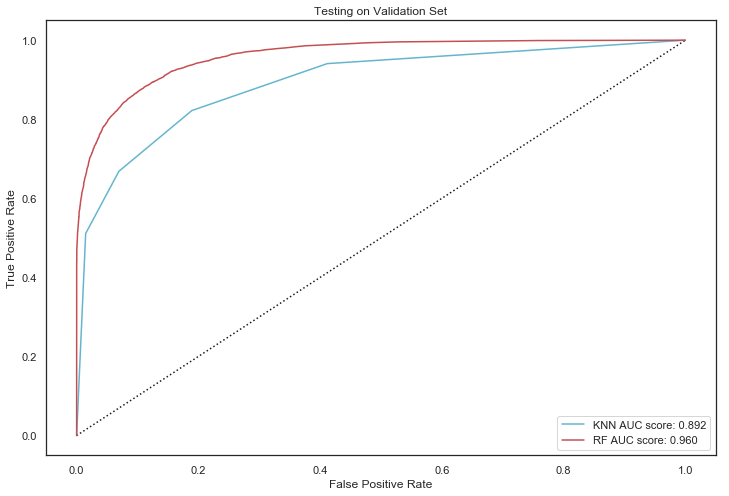

In [320]:
# Plot ROC and calcuate ROC-AUC scores for KNN and RF pipelines
# Both pipelines require re-fitting on training set due to difference in preprocessing parameters

# Create ROC curves from classification probabilities using predict_proba
knn_pipeline_tuned.fit(train_X, train_y)
predictions_knn = knn_pipeline_tuned.predict_proba(validate_X)[:,1]
fpr_knn, tpr_knn, _ = roc_curve(validate_y, predictions_knn, pos_label=1)

rf_pipeline_tuned.fit(train_X, train_y)
predictions_rf = rf_pipeline_tuned.predict_proba(validate_X)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(validate_y, predictions_rf, pos_label=1)

# Calculate auc scores 
auc_knn = roc_auc_score(validate_y, predictions_knn)
auc_rf = roc_auc_score(validate_y, predictions_rf)

# Plot ROC curves
plt.figure(figsize=(12,8))
plt.plot([0, 1], [0, 1], linestyle=':', color='k')
plt.plot(fpr_knn, tpr_knn, label=('KNN AUC score: %.3f' % auc_knn), color='c')
plt.plot(fpr_rf, tpr_rf, label=('RF AUC score: %.3f' % auc_rf), color='r')
plt.title('Testing on Validation Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

The dotted line in the graph depicts a hypothetical purely random classifier with an AUC of 0.50. This is graphed alongside the KNN and Random Forest ROC curves as a way to visualize how much better the models are than one that guesses randomly. 

The ROC curve for the random forest model is much better than the KNN's curve, given how much closer it is to the top left corner of the graph, making it the stronger model. In addition, the AUC score calculated for the random forest model is 0.96 vs. 0.892 for KNN.

Please remember that the classifiers being tested here are also accompanied by different preprocessing steps that were determined in the previous section.

## 5. Deploying Model on "Real-World" Data

The final step in this project is to deploy the models/pipelines on data that has never been seen before up until this point to simulate how well a model does when presented with data collected in the future. For this, the remaining 20% of the data that was set aside in the testing set will be used.

To recap, this KNN model uses 4 neighbors when voting and the hamming distance is used to find its neighbors. Prior the prediction, all countries that generate 500 or less bookings are grouped, agents are sorted into 3 equal width bins based on the number of bookings they generate, and the variance threshold to retain any given feature is 0.025.

For the random forest model contains 200 base estimators and subsets a maximum 40 features for each tree. And prior to prediction, all countries generating 20 or less bookings are grouped together, and agents are sorted into 10 equal width bins. There is no variance threshold in this pipeline.

In [323]:
# KNN - final prediction on test set
knn_pipeline.fit(train_X, train_y)
final_pred_knn = knn_pipeline.predict(test_X)
print(classification_report(test_y, final_pred_knn))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     14897
           1       0.85      0.66      0.74      8981

    accuracy                           0.83     23878
   macro avg       0.84      0.79      0.81     23878
weighted avg       0.83      0.83      0.82     23878



In [324]:
# Random Forest - final prediction on test set
rf_pipeline_tuned.fit(train_X, train_y)
final_pred_rf = rf_pipeline_tuned.predict(test_X)
print(classification_report(test_y, final_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     14897
           1       0.88      0.83      0.85      8981

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.88     23878
weighted avg       0.89      0.89      0.89     23878



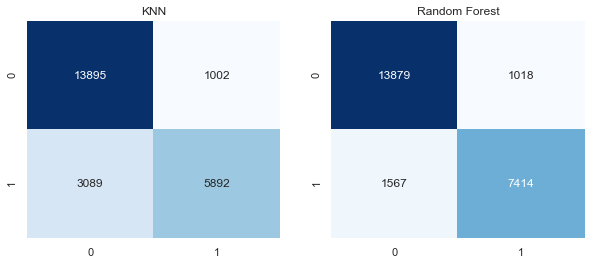

In [335]:
# Plotting confusion matrix
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(confusion_matrix(test_y, final_pred_knn), annot=True, cmap='Blues', cbar=False, fmt='g', ax=ax1)
ax1.set_title('KNN')
sns.heatmap(confusion_matrix(test_y, final_pred_rf), annot=True, cmap='Blues', cbar=False, fmt='g', ax=ax2)
ax2.set_title('Random Forest')
plt.show()

Out of 8981 actual cancellations in the test set, the KNN pipeline predicted 5892 of them (66% recall). In addition, it made 6894 predictions that a booking would be cancelled and was correct 5892 times (85% precision). 

The random forest pipeline model predicted 7414 cancellations out of the 8981 cancellations (83% recall). In addition, it made 8432 predictions that a booking would be cancelled and was correct 88% of the time. 

One thing to note is that KNN's precision for predicting cancellations is very close to that of random forest, 85% vs. 88%. So suppose hotel management was more focused on precision, and was not as concerned about the model missing actual cancellations. Then KNN would not be a bad model at all since its correct 85% of the time.